In [1]:
import sys
sys.path.insert(0, '../')

import os

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from ase import Atoms
from ase.io import read, write
from ase.optimize import BFGS
from ase.calculators.dftb import Dftb
from ase.neighborlist import NeighborList

from scipy.optimize import curve_fit, minimize

from cgf.cycles import find_cycles, cycle_graph
from cgf.motifs import find_unique_motifs
from cgf.utils import remove_hatoms
from cgf.baff import BAFFPotential
from cgf.bnff import MikadoPotential, _energy_total, _get_bonds, _get_phi0

In [3]:
def func(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3

In [3]:
# Tp Core Motif
motif = nx.Graph()
motif.add_edge("A", "B")
motif.add_edge("C", "B")
motif.add_edge("D", "B")

motif.nodes['A']['cl'] = 6
motif.nodes['B']['cl'] = 6
motif.nodes['C']['cl'] = 6
motif.nodes['D']['cl'] = 6

12
2


# Descriptors

In [7]:
def _find_linker_neighbor(cg_atoms, r0):
    
    natoms = len(cg_atoms)
    cell = cg_atoms.cell
    positions = cg_atoms.positions

    nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
    nl.update(cg_atoms)

    core_linker_dir = cg_atoms.get_array('linker_sites')
    phi0 = 2*np.pi/core_linker_dir.shape[1]

    core_linker_neigh = []
    # iterate over atoms
    for ii in range(natoms):
        neighbors, offsets = nl.get_neighbors(ii)
        cells = np.dot(offsets, cell)
        distance_vectors = positions[neighbors] + cells - positions[ii]

        linker_neigh = []
        # iterate over neighbors of ii
        for jj in range(len(neighbors)):
            v1 = distance_vectors[jj] # vector from ii to jj
            r1 = np.linalg.norm(v1)

#             print(v1)
            for li, v2 in enumerate(core_linker_dir[ii]):
                dot = np.dot(v1,v2)
                det = np.cross(v1,v2)[2]
                angle = np.arctan2(det, dot)

                if np.abs(angle) < phi0/2:
#                     print(ii, jj, li, angle)
                    linker_neigh.append(li)
                    break
        core_linker_neigh.append(linker_neigh)

    cg_atoms.new_array('linker_neighbors', np.array(core_linker_neigh)) # add linker site id for each neighbor 

In [109]:
def _get_core_descriptors(cg_atoms, r0):
    
    natoms = len(cg_atoms)
    cell = cg_atoms.cell
    positions = cg_atoms.positions

    nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
    nl.update(cg_atoms)

    core_linker_dir = cg_atoms.get_array('linker_sites')
    phi0 = 2*np.pi/core_linker_dir.shape[1]

    core_desc = []    
    # iterate over atoms
    for ii in range(natoms):
        neighbors, offsets = nl.get_neighbors(ii)
        cells = np.dot(offsets, cell)
        distance_vectors = positions[neighbors] + cells - positions[ii]

        angles = []
        for li in range(core_linker_dir.shape[1]):
            v1 = core_linker_dir[ii, li]
            
            for lj in range(li+1,core_linker_dir.shape[1]):

                v2 = core_linker_dir[ii, lj]

                dot = np.dot(v1,v2)
                det = np.cross(v1,v2)[2]
                angle = np.arctan2(det, dot)

#                 print(ii, li, lj, angle)
                angles.append(np.abs(angle))
        core_desc.append(angles)
    return core_desc

In [8]:
def _get_bond_descriptors(cg_atoms, r0, bonds):
    natoms = len(cg_atoms)
    cell = cg_atoms.cell
    positions = cg_atoms.positions
    core_linker_dir = cg_atoms.get_array('linker_sites')
    core_linker_neigh = cg_atoms.get_array('linker_neighbors')

    nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
    nl.update(cg_atoms)

    bond_desc = []
    for b in bonds:
        ii, nii, jj, njj = b[0], b[1], b[2], b[3]

        # get angle for site ii
        neighbors, offsets = nl.get_neighbors(ii)
        cells = np.dot(offsets, cell)
        distance_vectors = positions[neighbors] + cells - positions[ii]

        v2 = core_linker_dir[ii][core_linker_neigh[ii,nii]] # vector to linkage site
        v1 = distance_vectors[nii] # vector from ii to neighbor nii

        r1 = np.linalg.norm(v1)    
        r2 = np.linalg.norm(v2)

        dot = np.dot(v1,v2)
        det = np.cross(v1,v2)[2]
        phi_i = np.arctan2(det, dot)

        # get angle for site jj
        neighbors, offsets = nl.get_neighbors(jj)
        cells = np.dot(offsets, cell)
        distance_vectors = positions[neighbors] + cells - positions[jj]

        v2 = core_linker_dir[jj][core_linker_neigh[jj,njj]] # vector to linkage site
        v1 = distance_vectors[njj] # vector from jj to neighbor njj

        r1 = np.linalg.norm(v1)    
        r2 = np.linalg.norm(v2)

        dot = np.dot(v1,v2)
        det = np.cross(v1,v2)[2]
        phi_j = np.arctan2(det, dot)

        bond_desc.append([r1, phi_i, phi_j])

    return bond_desc

# Training with deformed unitcell

In [330]:
Zdict = {1:5, 2:8, 3:6, 4:1}

structures = read('../COF-MD/diboron_1-UFF/cof-elastic.atom', format='lammps-dump-text', index=':')

for s0 in structures:
    s0.set_atomic_numbers([Zdict[Z] for Z in s0.get_atomic_numbers()])
    remove_hatoms(s0)

In [331]:
structures[0]

Atoms(symbols='C54B6O12', pbc=True, cell=[[30.082699999999996, 0.0, 0.0], [-15.04135, 26.052382, 0.0], [0.0, 0.0, 30.0]])

In [332]:
cy = find_cycles(structures[0])

G_cy = cycle_graph(cy, structures[0].positions)

# annotate cycles with cycle length
for n in G_cy.nodes:
    G_cy.nodes[n]['cl'] = len(G_cy.nodes[n]['cycle'])

mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))

15
12
2


In [333]:
r0 = 30.082756/np.sqrt(3)

core_descriptors = []
bond_descriptors = []
for s0 in structures:
    G_cy = cycle_graph(cy, s0.positions)
    
    r_c = np.array([G_cy.nodes[m['B']]['pos'].mean(axis=0) for m in mfs]) # compute core centers
    core_linker_dir = [[G_cy.nodes[m[ls]]['pos'].mean(axis=0)-G_cy.nodes[m['B']]['pos'].mean(axis=0) for ls in ['A', 'C', 'D']] for m in mfs]
    
    cg_atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True) # create coarse-grained representation based on core centers
    cg_atoms.new_array('linker_sites', np.array(core_linker_dir)) # add positions of linker sites relative to core center
    
    _find_linker_neighbor(cg_atoms, r0)

    bonds = _get_bonds(cg_atoms, r0)
    bond_desc = _get_bond_descriptors(cg_atoms, r0, bonds)
    bond_descriptors.append(bond_desc)
    
    core_desc = _get_core_descriptors(cg_atoms, r0)
    core_descriptors.append(core_desc)    

In [110]:
_get_core_descriptors(cg_atoms, r0)

[[2.089395645695091, 2.096892817538548, 2.0968968439459474],
 [2.089399732866016, 2.096892787156785, 2.0968927871567855]]

In [100]:
_get_phi0(cg_atoms, r0)

array([3.68138565, 4.71238927])

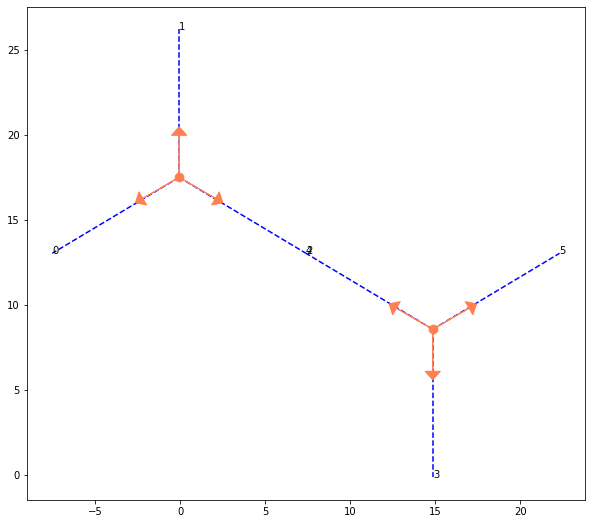

In [98]:
natoms = len(cg_atoms)
cell = cg_atoms.cell
positions = cg_atoms.positions
core_linker_dir = cg_atoms.get_array('linker_sites')
core_linker_neigh = cg_atoms.get_array('linker_neighbors')

nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
nl.update(cg_atoms)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(positions[:,0],positions[:,1], color='coral', marker='o', s=75, zorder=10)
for i in range(core_linker_dir.shape[0]):
    for li in range(core_linker_dir.shape[1]):
        ax.arrow(positions[i,0],positions[i,1], core_linker_dir[i,li,0], core_linker_dir[i,li,1], color='coral', head_width=0.9, head_length=0.5, zorder=10)

for ib,b in enumerate(bonds):
    ii, nii, jj, njj = b[0], b[1], b[2], b[3]

    # get angle for site ii
    neighbors, offsets = nl.get_neighbors(ii)
    cells = np.dot(offsets, cell)
    distance_vectors = positions[neighbors] + cells - positions[ii]

    v2 = core_linker_dir[ii][core_linker_neigh[ii,nii]] # vector to linkage site
    v1 = distance_vectors[nii] # vector from ii to neighbor nii        
    
    ax.plot([positions[ii][0], positions[ii][0]+v1[0]/2], [positions[ii][1], positions[ii][1]+v1[1]/2], 'b--')
    ax.annotate(str(ib), [positions[ii][0]+v1[0]/2, positions[ii][1]+v1[1]/2])
        
plt.show()

In [95]:
bonds

[[0, 0, 1, 2],
 [0, 1, 1, 0],
 [0, 2, 1, 1],
 [1, 0, 0, 1],
 [1, 1, 0, 2],
 [1, 2, 0, 0]]

In [94]:
bond_descriptors[16]

[[17.39399458742462, -0.01369449267848281, -0.013696536263945644],
 [17.425931758637155, 1.727789481688374e-06, -2.8541421830437495e-07],
 [17.39398605455219, 0.013694786599395038, 0.013696830184857426],
 [17.42593175863716, -2.8541421830437495e-07, 1.727789481688374e-06],
 [17.39398605455219, 0.013696830184857426, 0.013694786599395038],
 [17.39399458742462, -0.013696536263945644, -0.01369449267848281]]

In [115]:
len(bond_descriptors)

17

In [116]:
len(core_descriptors)

17

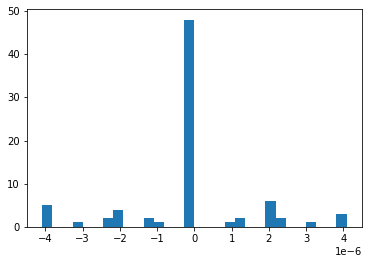

In [37]:
plt.hist(np.array(sum(bond_descriptors,[]))[:,1], bins=30)
plt.show()

In [334]:
data = np.loadtxt('../COF-MD/diboron_1-UFF/stress-strain.dat')
data = np.delete(data, 1, 0)
data

array([[   30.0827    ,    26.052382  ,    30.        , 23511.77975974,
            0.        ,   348.26074798],
       [   30.14289548,    26.10451282,    30.        , 23605.96804353,
            0.        ,   348.07084767],
       [   30.17303838,    26.13061733,    30.        , 23653.20358559,
            0.        ,   348.12002806],
       [   30.20321142,    26.15674795,    30.        , 23700.53364596,
            0.        ,   348.25641935],
       [   30.23341463,    26.18290469,    30.        , 23747.95841379,
            0.        ,   348.484382  ],
       [   30.26364804,    26.2090876 ,    30.        , 23795.47807857,
            0.        ,   348.80518871],
       [   30.29391169,    26.23529669,    30.        , 23843.09283021,
            0.        ,   349.21888113],
       [   30.3242056 ,    26.26153198,    30.        , 23890.80285896,
            0.        ,   349.72657928],
       [   30.35452981,    26.28779352,    30.        , 23938.60835548,
            0.        , 

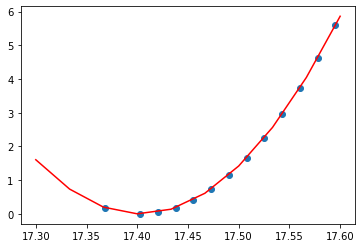

In [65]:
plt.scatter(np.array(sum(bond_descriptors,[]))[0::6,0], data[:,5]-data[:,5].min())
plt.plot(x,y,'r-')
plt.show()

In [335]:
# bonds
lenghts = np.array(bond_descriptors)[:,:,0]
psi0 = np.array(bond_descriptors)[:,:,1]
psi1 = np.array(bond_descriptors)[:,:,2]

# cores
dphi0 = np.array(core_descriptors)[:,:,0] - 2*np.pi/3
dphi1 = np.array(core_descriptors)[:,:,1] - 2*np.pi/3
dphi2 = np.array(core_descriptors)[:,:,2] - 2*np.pi/3

# feature matrix
X = np.array([lenghts.sum(axis=1), (lenghts**2).sum(axis=1), (psi0**2).sum(axis=1) , (psi1**2).sum(axis=1), (psi0*psi1).sum(axis=1), 
              (dphi0**2).sum(axis=1) + (dphi1**2).sum(axis=1) + (dphi2**2).sum(axis=1)]).T

# target values
y = data[:,5]-data[:,5].min()

In [329]:
X_shear = X.copy()
y_shear = y.copy()

In [336]:
y = np.concatenate((y,y_shear), axis=0)
X = np.concatenate((X,X_shear), axis=0)

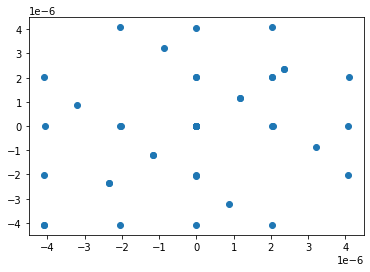

In [170]:
plt.scatter(psi0, psi1)
plt.show()

In [308]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [ ]:
reg = Ridge(alpha=1e-7).fit(X, y)
reg.score(X, y)

In [357]:
# reg = LinearRegression().fit(X, y)
reg = RidgeCV(alphas=[1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]).fit(X, y)
reg.score(X, y)

0.9999978532989207

In [358]:
reg.alpha_

1e-09

In [359]:
mean_squared_error(reg.predict(X), y)

4.4967495335348645e-06

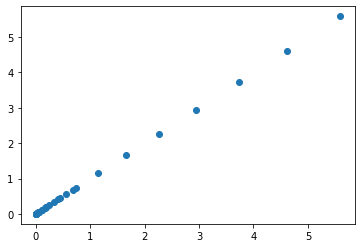

In [360]:
plt.scatter(reg.predict(X), y)
plt.show()

In [361]:
reg.coef_

array([-876.16543447,   25.17286545,  286.89630551,  286.89630551,
        286.89622429,   27.63704879])

In [342]:
reg.intercept_ = reg.intercept_ / 6

In [362]:
x = np.linspace(17.3,17.6,10)

In [363]:
yp = reg.predict(np.array([6*x, 6*x**2, np.zeros_like(x), np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)]).T)

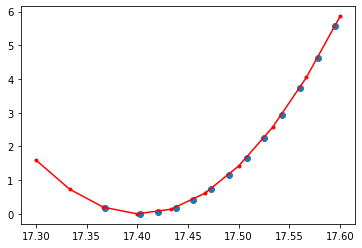

In [364]:
plt.scatter(lenghts[:,0], data[:,5]-data[:,5].min())
plt.plot(x,yp,'r.-')
plt.show()

In [365]:
x = np.linspace(-0.02,0.02,10)
x1 = 0.005
yp = reg.predict(np.array([6*np.ones_like(x)*17.4, 6*np.ones_like(x)*17.4**2, 6*x**2, 6*x**2, 6*x**2, np.zeros_like(x)]).T)

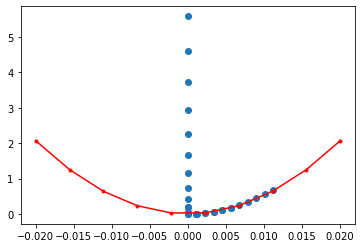

In [367]:
plt.plot(x,yp,'r.-')
plt.scatter(np.sqrt(X[:,2]/(6)), y)
plt.show()

# Prediction for defect structure

In [407]:
defect = read('../../COF-DFTB/Defect_DB/COF-5_opt_clean.gen')

In [372]:
# sys.path.insert(0, '/home/jupyter-acroy/Dev/lammps_interface/')
sys.path.insert(0, '/home/jupyter-acroy/Dev/li_tools/')

from lammps_interface.lammps_main import LammpsSimulation
from lammps_interface.structure_data import from_CIF
from lammps_interface.lammps_potentials import PairPotential
from lammps_interface.uff import UFF_DATA

from li_tools import Parameters

In [408]:
# os.chdir('tmp-defect')

cif_name = 'OF-5_opt_clean.cif'
write(cif_name, defect)

par = Parameters(cif_name, 'UFF')

sim = LammpsSimulation(par)
cell, graph = from_CIF(par.cif_file)
sim.set_cell(cell)
sim.set_graph(graph)
sim.assign_force_fields()

sim.write_lammps_files()

No bonds reported in cif file - computing bonding..
totatomlen = 864
compute_topology_information()
func: cartesian_coordinates; Elps. 0.010s
func: min_img_distances; Elps. 4.026s
func: compute_bonding; Elps. 5.393s
func: init_typing; Elps. 5.587s
func: bond_typing; Elps. 5.595s
func: angles; Elps. 5.597s
func: dihedrals; Elps. 5.602s
func: improper_dihedrals; Elps. 5.604s
Files created! -> /home/jupyter-acroy/COF-DFTB/tmp-defect


In [379]:
s0 = read('cof-geom.atom', format='lammps-dump-text')

s0.set_atomic_numbers([Zdict[Z] for Z in s0.get_atomic_numbers()])
remove_hatoms(s0)

cy = find_cycles(s0)

G_cy = cycle_graph(cy, s0.positions)

# annotate cycles with cycle length
for n in G_cy.nodes:
    G_cy.nodes[n]['cl'] = len(G_cy.nodes[n]['cycle'])

mfs = find_unique_motifs(motif, G_cy)
print(len(mfs))

151
108
18


In [380]:
r0 = 30.082756/np.sqrt(3)

core_descriptors = []
bond_descriptors = []

G_cy = cycle_graph(cy, s0.positions)

r_c = np.array([G_cy.nodes[m['B']]['pos'].mean(axis=0) for m in mfs]) # compute core centers
core_linker_dir = [[G_cy.nodes[m[ls]]['pos'].mean(axis=0)-G_cy.nodes[m['B']]['pos'].mean(axis=0) for ls in ['A', 'C', 'D']] for m in mfs]

cg_atoms = Atoms(['Y'] * len(r_c), positions=r_c, cell=s0.cell, pbc=True) # create coarse-grained representation based on core centers
cg_atoms.new_array('linker_sites', np.array(core_linker_dir)) # add positions of linker sites relative to core center

_find_linker_neighbor(cg_atoms, r0)

bonds = _get_bonds(cg_atoms, r0)
bond_desc = _get_bond_descriptors(cg_atoms, r0, bonds)
bond_descriptors.append(bond_desc)

core_desc = _get_core_descriptors(cg_atoms, r0)
core_descriptors.append(core_desc)    

In [404]:
len(bonds)

54

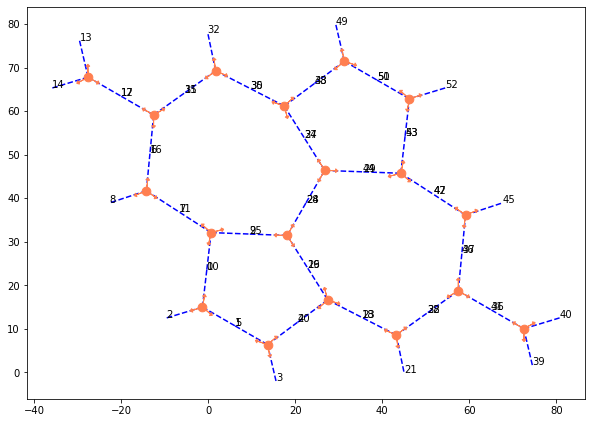

In [381]:
natoms = len(cg_atoms)
cell = cg_atoms.cell
positions = cg_atoms.positions
core_linker_dir = cg_atoms.get_array('linker_sites')
core_linker_neigh = cg_atoms.get_array('linker_neighbors')

nl = NeighborList( [1.2*r0/2] * natoms, self_interaction=False, bothways=True)
nl.update(cg_atoms)

fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(positions[:,0],positions[:,1], color='coral', marker='o', s=75, zorder=10)
for i in range(core_linker_dir.shape[0]):
    for li in range(core_linker_dir.shape[1]):
        ax.arrow(positions[i,0],positions[i,1], core_linker_dir[i,li,0], core_linker_dir[i,li,1], color='coral', head_width=0.9, head_length=0.5, zorder=10)

for ib,b in enumerate(bonds):
    ii, nii, jj, njj = b[0], b[1], b[2], b[3]

    # get angle for site ii
    neighbors, offsets = nl.get_neighbors(ii)
    cells = np.dot(offsets, cell)
    distance_vectors = positions[neighbors] + cells - positions[ii]

    v2 = core_linker_dir[ii][core_linker_neigh[ii,nii]] # vector to linkage site
    v1 = distance_vectors[nii] # vector from ii to neighbor nii        
    
    ax.plot([positions[ii][0], positions[ii][0]+v1[0]/2], [positions[ii][1], positions[ii][1]+v1[1]/2], 'b--')
    ax.annotate(str(ib), [positions[ii][0]+v1[0]/2, positions[ii][1]+v1[1]/2])
        
plt.show()

In [382]:
# bonds
lenghts = np.array(bond_descriptors)[:,:,0]
psi0 = np.array(bond_descriptors)[:,:,1]
psi1 = np.array(bond_descriptors)[:,:,2]

# cores
dphi0 = np.array(core_descriptors)[:,:,0] - 2*np.pi/3
dphi1 = np.array(core_descriptors)[:,:,1] - 2*np.pi/3
dphi2 = np.array(core_descriptors)[:,:,2] - 2*np.pi/3

X = np.array([lenghts.sum(axis=1), (lenghts**2).sum(axis=1), (psi0**2).sum(axis=1) , (psi1**2).sum(axis=1), (psi0*psi1).sum(axis=1), 
              (dphi0**2).sum(axis=1) + (dphi1**2).sum(axis=1) + (dphi2**2).sum(axis=1)]).T


In [405]:
reg.intercept_ = reg.intercept_ * 54/6

In [409]:
# final energy 
print(3132.66559876291 - 2603.94)
reg.predict(X)

528.7255987629101


array([577.47887183])

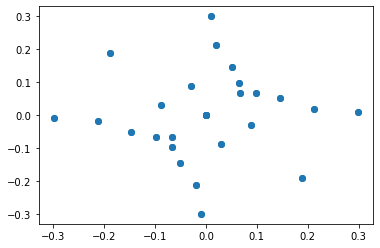

In [389]:
plt.scatter(psi0, psi1)
plt.show()

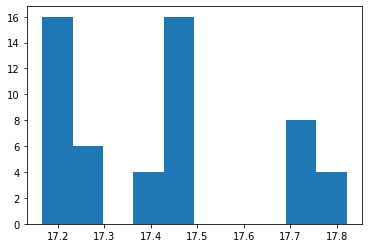

In [394]:
plt.hist(lenghts[0],bins=10)
plt.show()